# Introduction


A demo on model registry, adapted from [Quickstart Guide](https://quickstarts.snowflake.com/guide/intro_to_machine_learning_with,_snowpark_ml_for_python/#5), where we trained a model to predict price of a diamond based on its size, color, cut.

# Environment

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from snowflake.ml import dataset
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.registry import registry
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions
from snowflake.snowpark import functions
from snowflake.snowpark import Session


In [60]:
import os
from graphviz import Digraph
from IPython.display import Image, display

def render_graph(df) -> None:
    df = df.to_pandas()
    graph = Digraph()
    
    # Track the nodes already added to avoid duplication
    added_nodes = set()
    
    for index, row in df.iterrows():    
        source_node = str(row['SOURCE_OBJECT']).replace(':', '-').replace('{', '').replace('}', '')
        target_node = str(row['TARGET_OBJECT']).replace(':', '-').replace('{', '').replace('}', '')
        
        if source_node not in added_nodes:
            graph.node(source_node)
            added_nodes.add(source_node)

        
        if target_node not in added_nodes:
            graph.node(target_node)
            added_nodes.add(target_node)
        
        graph.edge(source_node, target_node)
    
    graph.render('graph.png', format='png', cleanup=True)
    graph.view()

# Setup Variables

In [2]:
session = Session.builder.configs(SnowflakeLoginOptions("ai307_ds")).create()

SnowflakeLoginOptions() is in private preview since 0.2.0. Do not use it in production. 


In [3]:
work_database = session.get_current_database()
work_schema = 'DATA'
data_table = 'DIAMONDS_DEMO'
train_data = 'TRAIN_DATA' 
test_data = 'TEST_DATA'

dataset_name = 'TRAINING_DATASET'

REGISTRY_DATABASE_NAME = work_database
REGISTRY_SCHEMA_NAME = 'REGISTRY'

model_name = 'diamonds_price_predictor'

## Bootstrap Data

In [64]:
# Read csv of diamonds data to a dataframe, set data_dir to path of your csv download
#file = 'diamonds.csv'
#df = pd.read_csv(file)

# Cleanup - remove row column and force headers to Uppercase
#df.columns = df.columns.str.upper()
#df.rename(columns={'TABLE': 'TABLE_PCT'}, inplace=True)

# write the DF to Snowflake and create a Snowflake DF
#session.write_pandas(df, data_table, auto_create_table=True, schema=work_schema)

#train_df, test_df = session.table(data_table).drop('ROW').random_split(weights=[0.9, 0.1], seed=0)
#session.write_pandas(train_df.to_pandas(), train_data, auto_create_table=True, schema=work_schema)
#session.write_pandas(test_df.to_pandas(), test_data, auto_create_table=True, schema=work_schema)

# Training

In [65]:
# Diamonds Snowflake Table
diamonds_df = session.table(data_table).drop('ROW')
print(diamonds_df.count())
print(diamonds_df.limit(10).to_pandas())

CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"]
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

LABEL_COLUMNS = ["PRICE"]
OUTPUT_COLUMNS = ["PREDICTED_PRICE"]

diamonds_train_df = session.table(train_data)
test_df = session.table(test_data)

107880
   CARAT        CUT COLOR CLARITY  DEPTH  TABLE_PCT  PRICE     X     Y     Z
0   0.23      Ideal     E     SI2   61.5       55.0    326  3.95  3.98  2.43
1   0.21    Premium     E     SI1   59.8       61.0    326  3.89  3.84  2.31
2   0.23       Good     E     VS1   56.9       65.0    327  4.05  4.07  2.31
3   0.29    Premium     I     VS2   62.4       58.0    334  4.20  4.23  2.63
4   0.31       Good     J     SI2   63.3       58.0    335  4.34  4.35  2.75
5   0.24  Very Good     J    VVS2   62.8       57.0    336  3.94  3.96  2.48
6   0.24  Very Good     I    VVS1   62.3       57.0    336  3.95  3.98  2.47
7   0.26  Very Good     H     SI1   61.9       55.0    337  4.07  4.11  2.53
8   0.22       Fair     E     VS2   65.1       61.0    337  3.87  3.78  2.49
9   0.23  Very Good     H     VS1   59.4       61.0    338  4.00  4.05  2.39


## Start with a dataset

In [66]:
ds = dataset.Dataset.create(session=session, name=dataset_name, exist_ok=True)
dsv2 = ds.select_version('v2')

In [67]:
training_df = dsv2.read.to_snowpark_dataframe()
training_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"              |"CUT"      |"COLOR"  |"CLARITY"  |"DEPTH"             |"TABLE_PCT"  |"PRICE"  |"X"                |"Y"                 |"Z"                 |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.23000000417232513  |Ideal      |E        |SI2        |61.5                |55.0         |326      |3.950000047683716  |3.9800000190734863  |2.430000066757202   |
|0.20999999344348907  |Premium    |E        |SI1        |59.79999923706055   |61.0         |326      |3.890000104904175  |3.8399999141693115  |2.309999942779541   |
|0.23000000417232513  |Good       |E        |VS1        |56.900001525878906  |65.0         |327      |4.050000190734863  |4.070000171661377   |2.309999942779541   |
|0.2899999

   PRICE  PREDICTED_PRICE
0    355       499.601837
1   2962      2781.700928
2   3228      2172.385498
3   3517      2783.982666
4   3780      4640.716797
Mean absolute percentage error: 0.18624602782995245


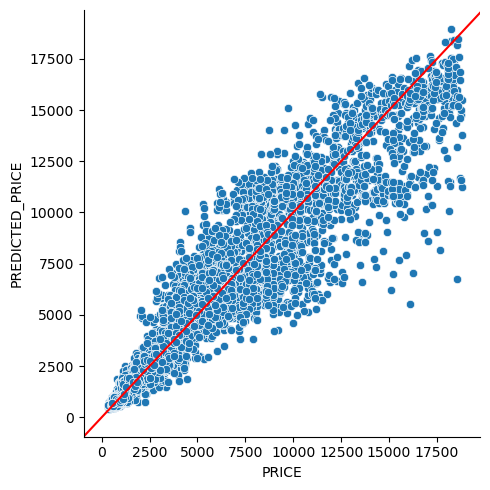

In [68]:
regressor = XGBRegressor(
    input_cols=NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(training_df)

# Eval
result = regressor.predict(test_df)

# Analyze results
df = result["PRICE", "PREDICTED_PRICE"].to_pandas()
print(df.head())
mean_absolute_pct_error = mean_absolute_percentage_error(df['PRICE'], df['PREDICTED_PRICE'])
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(df['PRICE'], df['PREDICTED_PRICE'])}")

g = sns.relplot(data=df, x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

# Intialize Model Registry

In [4]:
reg = registry.Registry(session=session, database_name=REGISTRY_DATABASE_NAME, schema_name=REGISTRY_SCHEMA_NAME)

# Creating Model

In [70]:
mv = reg.log_model(regressor,
                   model_name=model_name,
                   version_name='"1.0"',
                   sample_input_data=test_df,
                   )

/Users/sdas/miniconda3/envs/pt201whatsnew/lib/python3.9/contextlib.py:119: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)
/tmp/snowml/snowflake/ml/model/_packager/model_packager.py:92: UserWarning: Inferring model signature from sample input or providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(


In [71]:
mv = reg.log_model(regressor,
                   model_name=model_name,
                   sample_input_data=test_df,
                   comment = 'A XGB model trained from dataset v2',
                   )

# Using Model

## Model & Model Version APIs

In [72]:
reg.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2024-06-03 11:06:38.174000-07:00,DIAMONDS_PRICE_PREDICTOR,USER_MODEL,AI307_DS,REGISTRY,None,TASTY_DATA_SCIENTIST,1.0,"[""1.0"",""WEAK_PYTHON_1""]","{""DEFAULT"":""1.0"",""FIRST"":""1.0"",""LAST"":""WEAK_PY..."


In [5]:
m = reg.get_model(model_name)
m

In [74]:
m.description = 'A diamond price prediction model with inputs like size, color & cuts.'

In [75]:
reg.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2024-06-03 11:06:38.174000-07:00,DIAMONDS_PRICE_PREDICTOR,USER_MODEL,AI307_DS,REGISTRY,A diamond price prediction model with inputs l...,TASTY_DATA_SCIENTIST,1.0,"[""1.0"",""WEAK_PYTHON_1""]","{""DEFAULT"":""1.0"",""FIRST"":""1.0"",""LAST"":""WEAK_PY..."


In [76]:
m.show_versions()

,created_on,name,aliases,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-06-03 11:06:38.202000-07:00,1.0,"[""DEFAULT"",""FIRST""]",None,AI307_DS,REGISTRY,DIAMONDS_PRICE_PREDICTOR,true,"[""PREDICT""]",{},{}
1,2024-06-03 11:06:52.192000-07:00,WEAK_PYTHON_1,"[""LAST""]",A XGB model trained from dataset v2,AI307_DS,REGISTRY,DIAMONDS_PRICE_PREDICTOR,false,"[""PREDICT""]",{},{}


In [77]:
m.default = 'WEAK_PYTHON_1'

In [78]:
m.show_versions()

,created_on,name,aliases,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-06-03 11:06:38.202000-07:00,1.0,"[""FIRST""]",None,AI307_DS,REGISTRY,DIAMONDS_PRICE_PREDICTOR,false,"[""PREDICT""]",{},{}
1,2024-06-03 11:06:52.192000-07:00,WEAK_PYTHON_1,"[""DEFAULT"",""LAST""]",A XGB model trained from dataset v2,AI307_DS,REGISTRY,DIAMONDS_PRICE_PREDICTOR,true,"[""PREDICT""]",{},{}


In [6]:
mv = m.version('"1.0"')
mv

ModelVersion(
  name='DIAMONDS_PRICE_PREDICTOR',
  version='"1.0"',
)

In [80]:
mv.description = 'First version tried with a small dataset'

In [81]:
m.show_versions()

,created_on,name,aliases,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-06-03 11:06:38.202000-07:00,1.0,"[""FIRST""]",First version tried with a small dataset,AI307_DS,REGISTRY,DIAMONDS_PRICE_PREDICTOR,false,"[""PREDICT""]",{},{}
1,2024-06-03 11:06:52.192000-07:00,WEAK_PYTHON_1,"[""DEFAULT"",""LAST""]",A XGB model trained from dataset v2,AI307_DS,REGISTRY,DIAMONDS_PRICE_PREDICTOR,true,"[""PREDICT""]",{},{}


## Inference

In [82]:
mv.show_functions()

[{'name': 'PREDICT',
  'target_method': 'predict',
  'target_method_function_type': 'FUNCTION',
  'signature': ModelSignature(
                      inputs=[
                          FeatureSpec(dtype=DataType.DOUBLE, name='CARAT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='DEPTH'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='TABLE_PCT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='X'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='Y'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='Z')
                      ],
                      outputs=[
                          FeatureSpec(dtype=DataType.DOUBLE, name='CARAT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='DEPTH'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='TABLE_PCT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='X'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='Y'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='Z'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='PREDICTED_PRICE')
                      ]
                  )}]

In [84]:
remote_prediction = mv.run(test_df, function_name="predict")
remote_prediction.show()

------------------------------------------------------------------------------------------------------------------------
|"CUT"      |"COLOR"  |"CLARITY"  |"PRICE"  |"CARAT"  |"DEPTH"  |"TABLE_PCT"  |"X"   |"Y"   |"Z"   |"PREDICTED_PRICE"  |
------------------------------------------------------------------------------------------------------------------------
|Very Good  |J        |SI1        |351      |0.3      |62.7     |59.0         |4.21  |4.27  |2.66  |591.9641723632812  |
|Very Good  |J        |SI1        |353      |0.31     |59.4     |62.0         |4.39  |4.43  |2.62  |621.692626953125   |
|Premium    |I        |VS1        |355      |0.24     |62.5     |57.0         |3.97  |3.94  |2.47  |499.6018371582031  |
|Very Good  |D        |VS2        |357      |0.23     |60.5     |61.0         |3.96  |3.97  |2.4   |453.6365966796875  |
|Premium    |H        |SI1        |554      |0.3      |62.9     |59.0         |4.28  |4.24  |2.68  |717.2132568359375  |
|Premium    |H        |VVS2     

In [85]:
remote_prediction = m.default.run(test_df, function_name="predict")
remote_prediction.to_pandas()

,CUT,COLOR,CLARITY,PRICE,CARAT,DEPTH,TABLE_PCT,X,Y,Z,PREDICTED_PRICE
0,Good,E,VS2,2912,0.70,58.7,63.0,5.69,5.73,3.35,2347.635254
1,Ideal,H,VS2,3122,0.72,61.7,56.0,5.74,5.77,3.56,2988.656006
2,Premium,F,VS2,3429,0.80,61.6,58.0,5.98,6.03,3.70,3119.060791
3,Premium,J,VS2,3685,1.00,60.7,61.0,6.50,6.41,3.92,4625.031738
4,Good,F,SI1,3954,0.90,64.7,54.0,6.04,6.08,3.92,3552.214111
...,...,...,...,...,...,...,...,...,...,...,...
21385,Ideal,I,SI1,534,0.39,62.4,54.0,4.67,4.69,2.92,872.492981
21386,Fair,I,SI2,2129,0.91,65.0,58.0,6.05,6.02,3.92,3380.195068
21387,Good,D,VS2,2288,0.62,58.9,64.0,5.62,5.55,3.29,1789.939941
21388,Ideal,H,IF,2461,0.61,59.4,59.0,5.55,5.59,3.31,2059.314209


## Managing metadata

In [86]:
m.show_tags()

{}

In [87]:
m.get_tag('best_model')

In [88]:
m.set_tag('best_model', '"1.0"')

In [89]:
m.get_tag('best_model')

'"1.0"'

In [ ]:
m.unset_tag('best_model')

In [90]:
mv.version_name
mv.set_metric(metric_name="mean_absolute_pct_error", value=mean_absolute_pct_error)

In [91]:
mv.get_metric(metric_name="mean_absolute_pct_error")

0.18624602782995245

In [ ]:
mv.delete_metric(metric_name="mean_absolute_pct_error")

# Export or Load

In [92]:
!rm -rf /tmp/diamonds && mkdir /tmp/diamonds

In [93]:
mv.export('/tmp/diamonds')

In [94]:
!find /tmp/diamonds

/tmp/diamonds
/tmp/diamonds/model
/tmp/diamonds/model/model.yaml
/tmp/diamonds/model/runtimes
/tmp/diamonds/model/runtimes/cpu
/tmp/diamonds/model/runtimes/cpu/snowflake-ml-python.zip
/tmp/diamonds/model/runtimes/cpu/env
/tmp/diamonds/model/runtimes/cpu/env/requirements.txt
/tmp/diamonds/model/runtimes/cpu/env/conda.yml
/tmp/diamonds/model/models
/tmp/diamonds/model/models/DIAMONDS_PRICE_PREDICTOR
/tmp/diamonds/model/models/DIAMONDS_PRICE_PREDICTOR/model.pkl
/tmp/diamonds/model/env
/tmp/diamonds/model/env/requirements.txt
/tmp/diamonds/model/env/conda.yml


In [95]:
r = mv.load()
r

/tmp/snowml/snowflake/ml/_internal/telemetry.py:368: RuntimeWarning: Loading model requires to have the exact the same environment as the one when logging the model, otherwise, the model might be not functional or some other problems might occur.
  res = func(*args, **kwargs)


In [96]:
dir(r)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_align_expected_output_names',
 '_autogenerated',
 '_batch_inference_validate_snowpark',
 '_batch_size',
 '_check_dataset_type',
 '_check_input_cols',
 '_check_output_cols',
 '_class_name',
 '_compute',
 '_convert_attribute_dict_to_ndarray',
 '_create_sklearn_object',
 '_create_unfitted_sklearn_object',
 '_data_sources',
 '_deps',
 '_drop_input_cols',
 '_drop_input_columns',
 '_enforce_fit',
 '_fit',
 '_generate_model_signatures',
 '_get_active_columns',
 '_get_data_sources',
 '_get_dependencies',
 '_get_output_column_names',
 '_get_param_names',
 '_get_rand_id',
 '_infer_input_cols',
 '_infer_input_out

## Lineage

In [11]:
mv = m.version('WEAK_PYTHON_1')
mv

ModelVersion(
  name='DIAMONDS_PRICE_PREDICTOR',
  version='WEAK_PYTHON_1',
)

In [12]:
lnode = mv.lineage(direction="upstream")
lnode

[Dataset(
   name='AI307_DS.DATA.TRAINING_DATASET',
   version='v2',
 )]

In [14]:
dsv = lnode[0]
dsv

Dataset(
  name='AI307_DS.DATA.TRAINING_DATASET',
  version='v2',
)

In [15]:
dsv.read.to_snowpark_dataframe().show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"              |"CUT"      |"COLOR"  |"CLARITY"  |"DEPTH"             |"TABLE_PCT"  |"PRICE"  |"X"                |"Y"                 |"Z"                 |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.23000000417232513  |Ideal      |E        |SI2        |61.5                |55.0         |326      |3.950000047683716  |3.9800000190734863  |2.430000066757202   |
|0.20999999344348907  |Premium    |E        |SI1        |59.79999923706055   |61.0         |326      |3.890000104904175  |3.8399999141693115  |2.309999942779541   |
|0.23000000417232513  |Good       |E        |VS1        |56.900001525878906  |65.0         |327      |4.050000190734863  |4.070000171661377   |2.309999942779541   |
|0.2899999

In [13]:
df = session.lineage.trace("AI307_DS.DATA.TRAINING_DATASET", "DATASET",
                           object_version='v2', direction="downstream", distance=4)
df.show()

-------------------------------------------------------------------------------------------------------------------------------
|"SOURCE_OBJECT"                              |"TARGET_OBJECT"                                     |"DIRECTION"  |"DISTANCE"  |
-------------------------------------------------------------------------------------------------------------------------------
|{                                            |{                                                   |Downstream   |1           |
|  "createdOn": "2024-05-23T18:44:18Z",       |  "createdOn": "2024-06-06T05:27:04Z",              |             |            |
|  "domain": "DATASET",                       |  "domain": "MODEL",                                |             |            |
|  "name": "AI307_DS.DATA.TRAINING_DATASET",  |  "name": "AI307_DS.REGISTRY.DIAMONDS_PRICE_PRE...  |             |            |
|  "status": "ACTIVE",                        |  "status": "ACTIVE",                               |    

In [ ]:
render_graph(df)